In [1]:
import json
import argparse
from tqdm import tqdm

save_dir = 'math500_step32_max16384_trials10'
question_num = 10

All_data = {}

for question in range(0, question_num):
    for chunk in range(32, 16384 + 32, 32):
        file_name = save_dir + f"/question_{question}_tokens_{chunk}.json"
        try:
            with open(file_name, 'r') as f:
                data = json.load(f)
        except FileNotFoundError:
            continue
            raise FileNotFoundError(f"File {file_name} not found")
        All_data[f"question_{question}_tokens_{chunk}"] = data
    print(f"Processed question {question}")
with open(save_dir + f"/All_data.json", 'w') as f:
    json.dump(All_data, f)



Processed question 0


Processed question 1
Processed question 2
Processed question 3
Processed question 4
Processed question 5
Processed question 6
Processed question 7
Processed question 8
Processed question 9


In [2]:
def obtaint_answer(s):
    # Find first unpaired } by counting { and }
    stack = []
    for i, c in enumerate(s):
        if c == '{':
            stack.append(c)
        elif c == '}':
            if not stack:  # No matching { found
                return s[:i]
            stack.pop()
    return ""


def preprocess_data(all_data, problems):

    problem_sets = {}
    for i in range(problems):
        for r in range(10):
            problem_sets[f"{i}_{r}"] = {
                'target' : None,
                'is_finished' : [],
                'score' : [],
                'score_guide' : [],
                'probe_answers' : [],
                'probe_responses' : [],
                'probe_prompts' : [],
                'new_tokens' : [],
                'prompts' : []
            }

    for i in tqdm(range(problems)):
        for j in range(32, 16384 + 32, 32):
            if True:
                json_data = all_data[f"question_{i }_tokens_{j}"]
                target = json_data.get("target", None)
                is_finished = json_data.get("is_finished", None)
                score = json_data.get("is_corrects_original", None)
                score_guide = json_data.get("is_corrects", None)
                guided_answers = [obtaint_answer(prompt) for prompt in json_data.get("probe_responses", None)]
                probe_responses = json_data.get("probe_responses", None)
                probe_prompts = json_data.get("probe_prompts", None)
                responses = json_data.get("new_tokens", None)
                prompts = json_data.get("prompts", None)
                #print(len(data))
                for r in range(10):
                    problem_sets[f"{i}_{r}"]['target'] = target
                    problem_sets[f"{i}_{r}"]['is_finished'].append(is_finished[r])
                    problem_sets[f"{i}_{r}"]['score'].append(score[r])
                    problem_sets[f"{i}_{r}"]['score_guide'].append(score_guide[r])
                    problem_sets[f"{i}_{r}"]['probe_answers'].append(guided_answers[r])
                    problem_sets[f"{i}_{r}"]['probe_responses'].append(probe_responses[r])
                    problem_sets[f"{i}_{r}"]['probe_prompts'].append(probe_prompts[r])
                    problem_sets[f"{i}_{r}"]['new_tokens'].append(responses[r])
                    problem_sets[f"{i}_{r}"]['prompts'].append(prompts[r])

    return problem_sets

In [3]:
math500_data = json.load(open(f'math500_step32_max16384_trials10/All_data.json', 'r'))


In [4]:
problem_set_7b_math500 = preprocess_data(math500_data, question_num)


100%|██████████| 10/10 [00:00<00:00, 84.43it/s]


In [5]:
problem_set_outputs = {}

In [6]:
from collections import defaultdict

def standard_accuracy(problem_sets, problems,max_tokens=16384, unfinished_guide=False):
    #print('MAX TOKENS: ',max_tokens)
    all_scores = []
    all_scores_guide = []
    all_token_counts = []
    tokens_per_problem = [[] for _ in range(problems)]
    corrects_per_problem = [[] for _ in range(problems)]

    score_guide_dict = defaultdict(lambda: 0)
    score_dict = defaultdict(lambda: 0)
    for run in range(10):
        token_counts = []
        scores = []
        scores_guide = []
        for problem_id in range(problems):
            ended = False
            for step in range(0, max_tokens, 32):
                step_id = step // 32                
                finished = problem_sets[f"{problem_id}_{run}"]['is_finished'][step_id]
                score = problem_sets[f"{problem_id}_{run}"]['score'][step_id]
                score_guide = problem_sets[f"{problem_id}_{run}"]['score_guide'][step_id]

                if finished:
                    score_guide = score
                    token_counts.append(step + 32)
                    ended = True
                    break 
            if not ended:
                token_counts.append(max_tokens)
                if unfinished_guide:
                    score = problem_sets[f"{problem_id}_{run}"]['score_guide'][max_tokens // 32 - 1]
                else:
                    score = problem_sets[f"{problem_id}_{run}"]['score'][max_tokens // 32 - 1]
                score_guide = problem_sets[f"{problem_id}_{run}"]['score_guide'][max_tokens // 32 - 1]

            for step in range(0, max_tokens, 32):
                #datas[problem_id][step] += int(score_guide)
                step_id = step // 32
                score_dict[f"{problem_id}_{step}"] += problem_sets[f"{problem_id}_{run}"]['score'][step_id]
                score_guide_dict[f"{problem_id}_{step}"] += problem_sets[f"{problem_id}_{run}"]['score_guide'][step_id]

            #correct_dict[(problem_id, run)] = score
            scores.append( score)
            scores_guide.append(score_guide)
            tokens_per_problem[problem_id].append(token_counts[-1])
            corrects_per_problem[problem_id].append(score)
        all_scores.extend(scores)
        all_token_counts.extend(token_counts)
        all_scores_guide.extend(scores_guide)
    return all_scores, all_scores_guide, all_token_counts, score_dict, score_guide_dict, tokens_per_problem, corrects_per_problem

def store_standard_outputs(problem_set_name, problem_set, problems, max_tokens=16384):
    if problem_set_name not in problem_set_outputs:
        problem_set_outputs[problem_set_name] = {}
    scores = []
    scores_guide = []
    tokens_counts = []
    score_dict = []
    score_guide_dict = []
    tokens_per_problem = []
    corrects_per_problem = []
    for tokens in tqdm(range(1024, max_tokens + 1024, 1024)): 
    # Store standard accuracy results
        #print('tks: ', tokens)
        standard_outputs = standard_accuracy(
            problem_set,
            problems, 
            tokens,
            unfinished_guide=False
        )
        scores.append(standard_outputs[0])
        scores_guide.append(standard_outputs[1])
        tokens_counts.append(standard_outputs[2])
        score_dict.append(standard_outputs[3])
        score_guide_dict.append(standard_outputs[4])
        tokens_per_problem.append(standard_outputs[5])
        corrects_per_problem.append(standard_outputs[6])
    problem_set_outputs[problem_set_name][f"standard_0"] = {
        'scores': scores,
        'scores_guide': scores_guide,
        'token_counts': tokens_counts,
        'unfinished_guide': False, # Flag for unfinished guide results
        'score_dict': score_dict,
        'score_guide_dict': score_guide_dict,
        'tokens_per_problem': tokens_per_problem,
        'corrects_per_problem': corrects_per_problem
    }



In [7]:
store_standard_outputs('math500', problem_set_7b_math500, question_num)

100%|██████████| 16/16 [00:00<00:00, 44.44it/s]


In [8]:
data = []
for problem_id in range(question_num):
    for step in range(0, 16384, 32):
        data.append({
            "Problem ID": problem_id,
            "Token Budget": step,
            "Score": problem_set_outputs['math500']['standard_0']['score_dict'][-1][f"{problem_id}_{step}"]
        })


data_guide = []
for problem_id in range(question_num):
    for step in range(0, 16384, 32):
        data_guide.append({
            "Problem ID": problem_id,
            "Token Budget": step,
            "Score": problem_set_outputs['math500']['standard_0']['score_guide_dict'][-1][f"{problem_id}_{step}"]
        })


   Problem ID  Token Budget  Score
0           0             0      0
1           0            32      0
2           0            64      0
3           0            96      0
4           0           128      0
You have 5120 rows


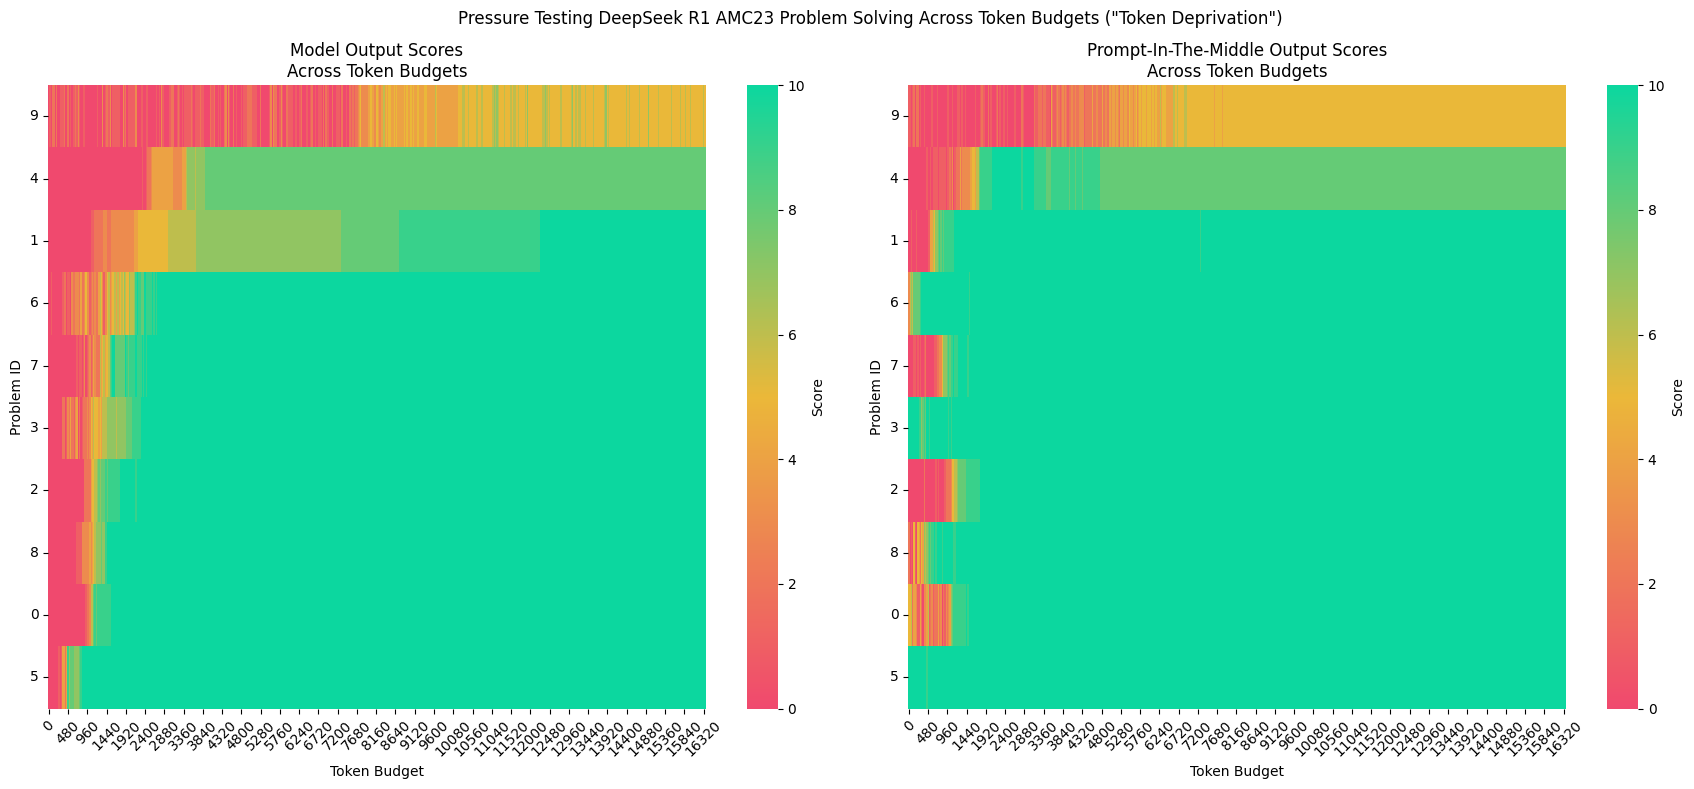

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os
import glob
from tqdm import tqdm

# Load data from JSON files
# with open('data-cot.json', 'r') as f:
#     data = json.load(f)

# with open('data_guide-cot.json', 'r') as f:
#     data_guide = json.load(f)

# Convert pivot table to pandas DataFrame
df = pd.DataFrame(data)
df_guide = pd.DataFrame(data_guide)
print (df.head())
print (f"You have {len(df)} rows")
pivot_table= df
pivot_table = pd.pivot_table(df, values='Score', index=['Problem ID', 'Token Budget'], aggfunc='mean').reset_index() # This will aggregate
pivot_table = pivot_table.pivot(index="Problem ID", columns="Token Budget", values="Score") # This will turn into a proper pivot
pivot_table.iloc[:5, :5]

pivot_table_guide = pd.DataFrame(data_guide)
pivot_table_guide = pd.pivot_table(df_guide, values='Score', index=['Problem ID', 'Token Budget'], aggfunc='mean').reset_index() # This will aggregate
pivot_table_guide = pivot_table_guide.pivot(index="Problem ID", columns="Token Budget", values="Score") # This will turn into a proper pivot

# Calculate row sums for pivot_table and get the sorting order
row_sums = pivot_table.sum(axis=1)
sort_order = row_sums.argsort()

# Sort both pivot tables using the same order from pivot_table
pivot_table = pivot_table.iloc[sort_order]
pivot_table_guide = pivot_table_guide.iloc[sort_order]

# Create a custom colormap. Go to https://coolors.co/ and pick cool colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

# Create figure with two subplots side by side
plt.figure(figsize=(17.5, 8))

# First subplot for pivot_table
plt.subplot(1, 2, 1)
sns.heatmap(
    pivot_table,
    fmt="g",
    cmap=cmap,
    cbar_kws={'label': 'Score'}
)
plt.title('Model Output Scores\nAcross Token Budgets')
plt.xlabel('Token Budget')
plt.ylabel('Problem ID')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Second subplot for pivot_table_guide
plt.subplot(1, 2, 2)
sns.heatmap(
    pivot_table_guide,
    fmt="g", 
    cmap=cmap,
    cbar_kws={'label': 'Score'}
)
plt.title('Prompt-In-The-Middle Output Scores\nAcross Token Budgets')
plt.xlabel('Token Budget')
plt.ylabel('Problem ID')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.suptitle('Pressure Testing DeepSeek R1 AMC23 Problem Solving Across Token Budgets ("Token Deprivation")')
plt.tight_layout()

# Show the plots
plt.show()
